In [5]:
# !pip install xgboost

In [6]:
import os
import glob
import time
import warnings

import numpy as np
import pandas as pd
# import altair as alt
import seaborn as sns

from numpy import mean, std
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from collections import defaultdict


from datetime import datetime
# from dataprep.eda import plot
from sklearn.metrics import f1_score, recall_score, precision_score
# from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Executive summary.
This project aims to thoroughly investigate a telecom company's customer base, focusing on holistic customer understanding and identifying highly responsive segments for marketing campaigns. I conducted a comprehensive EDA and employed various statistical models, including parametric and non-parametric ones. Our chosen model improved performance by 69% over the baseline Zero Rate Classifier.

# Problem definition.
The company has recently launched a marketing campaign to promote the adoption of the new subscription plan among customers.

Data: the data of the campaign is stored in a CSV file containing 21 columns and 41180 records, divided into three categories:
- Details of current and past marketing campaigns: contact duration, previous outcome, etc.
- Customer demographics: age, marital status, education, etc.
- Social indicators: customer confidence and price index, employment rate, etc.

- Target variable: "y", with 1 indicating the customer subscribed to the telecom plan and 0 showing otherwise



# A. Exploratory Data Analysis (EDA).

In the EDA (the EDA is conducted in a separate [notebook](https://github.com/phamthiminhtu/data_science_projects/blob/master/classification_marketing__campaigns_EDA.ipynb)),   various data cleaning techniques were employed, addressing missing values and outliers.
Some insights about the data were explored, such as data imbalance, predictor correlations, and their relationship with the target variable, y, with 1 indicating the customer subscribed to the telecom plan and 0 showing otherwise.


# B. Modelling.

## Models.
Models used in this project:
- Bayesian Logistic Regression (using Bambi)
- Logistic Regression (MLE, using statsmodels)
- Decision Trees
- XGBoost

## Training procedure.
To evaluate the performance of our models, I employed the following cross-validation approach:
- Split the data into training and testing sets.
- Employ 3-fold cross-validation on the training data to tune hyperparameters.
- For each model, test various probability thresholds (from 0.1 to 1) to classify the
target variable and select the optimal threshold with the highest F1 score.
- Identify the model with the best performance on the validation data.
- Retrain the chosen model on the whole training subset using optimal
hyperparameters.
- Test model generalizability on the testing subset.

Exception: due to computation complexity of the Bayesian model, the above procedure is not applied to Bayesian Logistic Regression.

## 1. Import and split data.

In [8]:
# import cleaned data
df = pd.read_csv('datasets/classification__marketing_campaigns.csv')

In [43]:
# rename columns
columns = ['education', 'default', 'housing', 'loan', 'age', 'duration',
'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx',
'cons_conf_idx', 'job_admin', 'job_blue_collar', 'job_entrepreneur',
'job_housemaid', 'job_management', 'job_retired', 'job_self_employed',
'job_services', 'job_student', 'job_technician', 'job_unemployed',
'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
'contact_cellular', 'contact_telephone', 'poutcome_failure',
'poutcome_nonexistent', 'poutcome_success', 'y']

df.columns = columns

In [9]:
df.head(5)

,education,default,housing,loan,age,duration,campaign,pdays,previous,emp.var.rate,...,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,2,0,0,0,40.0,151.0,1.0,999.0,0.0,1.1,...,0,0,1,0,0,1,0,1,0,0
1,4,0,0,1,56.0,307.0,1.0,999.0,0.0,1.1,...,0,0,1,0,0,1,0,1,0,0
2,3,0,0,0,45.0,198.0,1.0,999.0,0.0,1.1,...,0,0,1,0,0,1,0,1,0,0
3,5,0,0,0,59.0,139.0,1.0,999.0,0.0,1.1,...,0,0,1,0,0,1,0,1,0,0
4,0,0,0,0,41.0,217.0,1.0,999.0,0.0,1.1,...,0,0,1,0,0,1,0,1,0,0


In [10]:
df.shape

(41168, 33)

In [44]:
target = 'y'
predictors = [c for c in df.columns if c != target]
encoded_predictors = [
    'housing',
    'loan',
    'education',
    'job_admin',
    'job_blue_collar',
    'job_entrepreneur',
    'job_housemaid',
    'job_management',
    'job_retired',
    'job_self_employed',
    'job_services',
    'job_student',
    'job_technician',
    'job_unemployed',
    'job_unknown',
    'marital_divorced',
    'marital_married',
    'marital_single',
    'contact_cellular',
    'contact_telephone',
    'poutcome_failure',
    'poutcome_nonexistent',
    'poutcome_success'
]
X_train_val, X_test, y_train_val, y_test = train_test_split(
                            df[predictors],
                            df[target],
                            test_size=0.2,
                            random_state=3)

df_train_val = pd.concat([X_train_val, y_train_val], axis=1).reset_index(drop=True)
print('Train data', df_train_val.shape)
print(f"y_train_val distribution: 1: {sum(y_train_val)/len(y_train_val)*100}% | 0: {(len(y_train_val)- sum(y_train_val))/len(y_train_val)*100}%")
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
print('Test data', df_test.shape)
print(f"y_test distribution: 1: {sum(y_test)/len(y_test)*100}% | 0: {(len(y_test)- sum(y_test))/len(y_test)*100}%")

Train data (32934, 33)
y_train_val distribution: 1: 11.313536163235561% | 0: 88.68646383676445%
Test data (8234, 33)
y_test distribution: 1: 11.063881467087686% | 0: 88.93611853291232%


In [12]:
# Define the number of folds for cross-validation
n_folds = 3

# Define F1 score average
f1_average = "macro"
random_state = 34
metrics = ['train_f1_score', 'train_precision', 'train_recall', 'validation_f1_score', 'val_precision', 'val_recall']

# Perform cross-validation
skf = StratifiedKFold(n_splits=n_folds)

## 2. Assess the baseline.

In [13]:
from scipy.stats import mode

baseline_train_f1_scores = []
baseline_val_f1_scores = []
# split data for baseline model
for train_index, test_index in skf.split(df_train_val[predictors], df_train_val[target]):
    y_train, y_val = df_train_val[target][train_index].reset_index(drop=True), df_train_val[target][test_index].reset_index(drop=True)

    # get the mode of y_train as the prediction
    y_mode = mode(y_train)[0]
    y_base_train = np.full(y_train.shape, y_mode)
    y_base_val = np.full(y_val.shape, y_mode)

    # calculate F1 score for baseline on both train and validation datasets
    baseline_f1_train = f1_score(y_train, y_base_train, average=f1_average)
    baseline_f1_val = f1_score(y_val, y_base_val, average=f1_average)
    baseline_train_f1_scores.append(baseline_f1_train)
    baseline_val_f1_scores.append(baseline_f1_val)

print("Mean baseline training F1 score", mean(baseline_train_f1_scores))
print("Mean baseline validation F1 score", mean(baseline_val_f1_scores))

Mean baseline training F1 score 0.47002027614173986
Mean baseline validation F1 score 0.47002027614173986


In [14]:
def choose_the_best_threshold(y_prob, y_val, f1_average, scoring='f1_score'):
    '''
        Choose the probability threshold to classify the positive label.
        The best probability threshold is the one with the highest F1 score.
    '''
    thresholds = [i/10 for i in range(1, 11)]
    scores = []

    if scoring == 'f1_score':
        for threshold in thresholds:
            y_val_pred = (y_prob > threshold).astype(int)
            score = f1_score(y_val, y_val_pred, average=f1_average)
            scores.append(score)
    else:
        raise 'Scoring is not supported.'
    index = np.argmax(scores)
    return thresholds[index]

In [15]:
def compute_performance_metrics(
    model,
    x_train,
    y_train,
    x_val,
    y_val,
    scoring='f1_score',
    f1_average='macro',
    predict_function='predict'
):
    # statsmodel, scikit learn and xgboost have different functions to predict probability
    if predict_function == 'predict':
        y_train_prob = model.predict(x_train)
        y_val_prob = model.predict(x_val)
    else:
        # get model.predict_proba(x_train)[:,1] because the classes are sorted numerically with index https://scikit-learn.org/stable/glossary.html#term-classes_:~:text=the%20classes%20should%20be%20sorted
        y_train_prob = model.predict_proba(x_train)[:,1]
        y_val_prob = model.predict_proba(x_val)[:,1]

    if scoring == 'f1_score':
        # find the optimal threshold for f1 score
        optimal_threshold = choose_the_best_threshold(
            y_prob=y_val_prob,
            y_val=y_val,
            f1_average=f1_average,
            scoring=scoring
        )
        # get labels
        y_train_pred = (y_train_prob > optimal_threshold).astype(int)
        y_val_pred = (y_val_prob > optimal_threshold).astype(int)
    else:
        raise 'Scoring is not supported.'

    # compute scores
    train_f1_score = f1_score(y_train, y_train_pred, average=f1_average)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    validation_f1_score = f1_score(y_val, y_val_pred, average=f1_average)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)

    print('Optimal threshold:', optimal_threshold)
    performance = {
        'train_f1_score': train_f1_score,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'validation_f1_score': validation_f1_score,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'optimal_threshold': optimal_threshold
    }
    return performance, y_val_pred

## 3. Modelling.

### 3.1. Bayesian Logistic Regression

In [163]:
# !pip install bambi

In [35]:
import arviz as az
import bambi as bmb

In [36]:
# Disable a FutureWarning in ArviZ at the moment of running the notebook
az.style.use("arviz-darkgrid")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [69]:
# split data
X_train, X_val = df_train_val[predictors].iloc[train_index, :].reset_index(drop=True), df_train_val[predictors].iloc[test_index, :].reset_index(drop=True)
y_train, y_val = df_train_val[target][train_index].reset_index(drop=True), df_train_val[target][test_index].reset_index(drop=True)

predictors_bayesian = [p for p in predictors if p != 'default'] # remove default containing mostly 0 thus is detected as constant by the model
non_encoded_predictors = [p for p in predictors_bayesian if p not in encoded_predictors]

# scale data, only scale for continuous predictors
scaler = StandardScaler()
scaler.fit(X_train[non_encoded_predictors])

X_train_scaled = scaler.transform(X_train[non_encoded_predictors])
X_val_scaled = scaler.transform(X_val[non_encoded_predictors])

df_train_scaled = pd.concat(
    [
        pd.DataFrame(X_train_scaled, columns=non_encoded_predictors),   # scaled continuous predictors
        X_train[encoded_predictors], # encoded predictors
        y_train
    ],
    axis=1
)
df_val_scaled = pd.concat(
    [
        pd.DataFrame(X_val_scaled, columns=non_encoded_predictors),
        X_val[encoded_predictors],
        y_val
    ],
    axis=1
)

predictors_str = ' + '.join(predictors_bayesian)
full_model = f'{target} ~ {predictors_str}'

In [70]:
# source: https://bambinos.github.io/bambi/notebooks/model_comparison.html
model1 = bmb.Model(full_model, df_train_scaled, family="bernoulli")
fitted1 = model1.fit(draws=1000, idata_kwargs={"log_likelihood": True})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.261,7.683,-17.549,11.255,0.225,0.159,1163.0,1203.0,1.00
education,0.026,0.018,-0.007,0.059,0.000,0.000,2933.0,1558.0,1.00
housing,-0.031,0.056,-0.139,0.070,0.001,0.001,2902.0,1500.0,1.00
loan,-0.085,0.075,-0.224,0.054,0.001,0.001,2824.0,1506.0,1.00
age,0.030,0.033,-0.030,0.093,0.001,0.001,2503.0,1684.0,1.00
duration,1.187,0.026,1.140,1.238,0.001,0.000,2309.0,1352.0,1.00
campaign,-0.112,0.041,-0.185,-0.031,0.001,0.001,2902.0,1577.0,1.00
pdays,-0.168,0.056,-0.267,-0.054,0.001,0.001,1990.0,1254.0,1.00
previous,-0.029,0.040,-0.101,0.045,0.001,0.001,2111.0,1437.0,1.00
emp_var_rate,-1.463,0.046,-1.553,-1.380,0.001,0.001,1839.0,1560.0,1.00


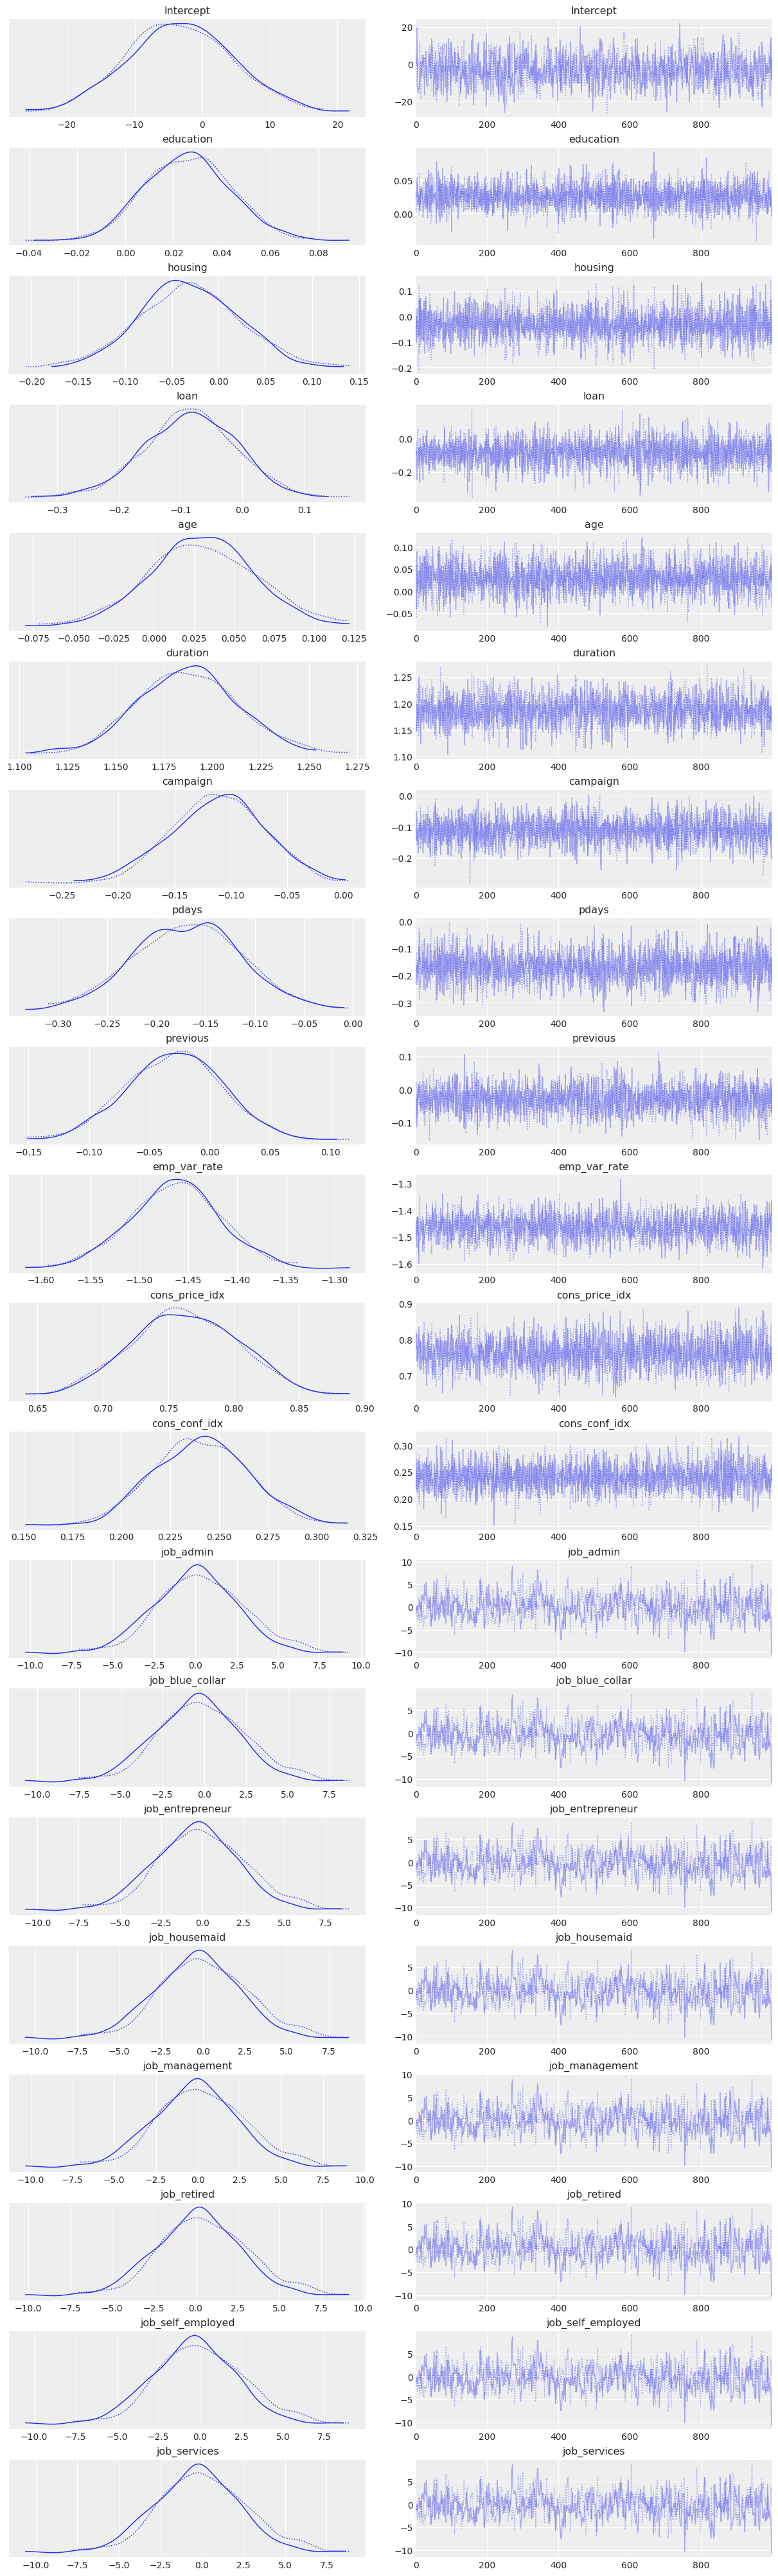

In [72]:
az.plot_trace(fitted1);
az.summary(fitted1)

The trace plots show that the model has converged.

These predictors are statistically significant in predicting the success of the campaign because their 95% Credible Interval posterior distributions does not contain 0:
- duration
- campaign
- pdays
- emp_var_rate
- cons_price_idx
- cons_conf_idx

In [126]:
prediction_train = model1.predict(fitted1, data=df_train_scaled[predictors_bayesian], inplace=False)
train_posterior_mean = np.average(prediction_train.posterior.y_mean.values.mean(0).T, axis=1)
prediction_val = model1.predict(fitted1, data=df_val_scaled[predictors_bayesian], inplace=False)
val_posterior_mean = np.average(prediction_val.posterior.y_mean.values.mean(0).T, axis=1)

In [127]:
optimal_threshold = 0.3
y_train_pred = (train_posterior_mean > optimal_threshold).astype(int)
y_val_pred = (val_posterior_mean > optimal_threshold).astype(int)
# compute scores
train_f1_score = f1_score(y_train, y_train_pred, average=f1_average)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
validation_f1_score = f1_score(y_val, y_val_pred, average=f1_average)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print('Optimal threshold:', optimal_threshold)
performance = {
    'train_f1_score': train_f1_score,
    'train_precision': train_precision,
    'train_recall': train_recall,
    'validation_f1_score': validation_f1_score,
    'val_precision': val_precision,
    'val_recall': val_recall,
    'optimal_threshold': optimal_threshold
}

Optimal threshold: 0.3


In [132]:
# save model performance into a dataframe
performance_data = {
    'train': [
        mean(performance.get('train_f1_score')),
        mean(performance.get('train_precision')),
        mean(performance.get('train_recall'))
    ],
    'val': [
        mean(performance.get('validation_f1_score')),
        mean(performance.get('val_precision')),
        mean(performance.get('val_recall'))
    ]
}
bayesian_lr_df = pd.DataFrame.from_dict(
    performance_data,
    orient='index',
    columns=['mean_f1_score', 'mean_precision', 'mean_recall']
).reset_index()

bayesian_lr_df['model'] = 'Bayesian Logistic Regression'
bayesian_lr_df

,index,mean_f1_score,mean_precision,mean_recall,model
0,train,0.77279,0.585648,0.611111,Bayesian Logistic Regression
1,val,0.77642,0.585973,0.625604,Bayesian Logistic Regression


### 3.2. Logistic Regression (MLE)

In [16]:
import statsmodels.api as sm

In [17]:
performances = defaultdict(list)
for i, (train_index, test_index) in enumerate(skf.split(df_train_val[predictors], df_train_val[target])):
    print("Fold:", i)

    # remove "default" because it caused "Singular matrix" error
    # due to low cardinality
    predictors_lr = [p for p in predictors if p != 'default']
    non_encoded_predictors = [p for p in predictors_lr if p not in encoded_predictors]

    # split data
    X_train, X_val = df_train_val[predictors_lr].iloc[train_index, :].reset_index(drop=True), df_train_val[predictors_lr].iloc[test_index, :].reset_index(drop=True)
    y_train, y_val = df_train_val[target][train_index].reset_index(drop=True), df_train_val[target][test_index].reset_index(drop=True)

    # scale data, only scale for continuous predictors
    scaler = StandardScaler()
    scaler.fit(X_train[non_encoded_predictors])

    X_train_scaled = scaler.transform(X_train[non_encoded_predictors])
    X_val_scaled = scaler.transform(X_val[non_encoded_predictors])

    non_encoded_predictors = ['const'] + non_encoded_predictors

    # Add a constant column to the DataFrame
    # and concat encoded predictors with scaled continuous predictors
    X_train_scaled_w_const = pd.concat(
        [
            pd.DataFrame(sm.add_constant(X_train_scaled), columns=non_encoded_predictors),   # scaled continuous predictors
            X_train[encoded_predictors] # encoded predictors
        ],
        axis=1
    )
    X_val_scaled_w_const = pd.concat(
        [
            pd.DataFrame(sm.add_constant(X_val_scaled, has_constant='add'), columns=non_encoded_predictors),
            X_val[encoded_predictors]
        ],
        axis=1
    )

    # Fit the logistic regression model using statsmodels
    logit = sm.Logit(y_train, X_train_scaled_w_const)
    result = logit.fit()

    # Print the model summary, only print once
    if i == 2:
        print(result.summary())

    # Compute the validation score
    performance, y_val_pred = compute_performance_metrics(
                    model=result,
                    x_train=X_train_scaled_w_const,
                    y_train=y_train,
                    x_val=X_val_scaled_w_const,
                    y_val=y_val,
                    scoring='f1_score',
                    f1_average=f1_average
                )

    for metric in metrics:
        performances[metric].append(performance.get(metric))

Fold: 0
Optimization terminated successfully.
         Current function value: 0.214844
         Iterations 8
Optimal threshold: 0.3
Fold: 1
Optimization terminated successfully.
         Current function value: 0.216368
         Iterations 8
Optimal threshold: 0.3
Fold: 2
Optimization terminated successfully.
         Current function value: 0.217578
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                21956
Model:                          Logit   Df Residuals:                    21928
Method:                           MLE   Df Model:                           27
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:                  0.3837
Time:                        05:30:08   Log-Likelihood:                -4777.2
converged:                       True   LL-Null:                       -7750.9
Covariance Type:            nonrobust   LLR p-value:                   

In [18]:
# save model performance into a dataframe
performance_data = {
    'train': [
        mean(performances.get('train_f1_score')),
        mean(performances.get('train_precision')),
        mean(performances.get('train_recall'))
    ],
    'val': [
        mean(performances.get('validation_f1_score')),
        mean(performances.get('val_precision')),
        mean(performances.get('val_recall'))
    ]
}
lr_performance_df = pd.DataFrame.from_dict(
    performance_data,
    orient='index',
    columns=['mean_f1_score', 'mean_precision', 'mean_recall']
).reset_index()

lr_performance_df['model'] = 'Logistic Regression'
lr_performance_df

,index,mean_f1_score,mean_precision,mean_recall,model
0,train,0.774247,0.588238,0.613661,Logistic Regression
1,val,0.773735,0.585972,0.614600,Logistic Regression


Text(0.5, 1.0, 'Confusion matrix on validation dataset. Mean f1_score=0.774.')

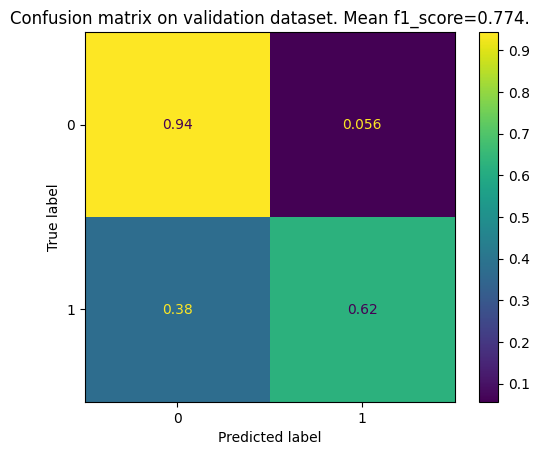

In [19]:
mean_val_f1_score = mean(performances.get('validation_f1_score'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred, normalize='true'))
disp.plot()
plt.title(f'Confusion matrix on validation dataset. Mean f1_score={round(mean_val_f1_score, 3)}.')

### 3.3. Decision Tree

In [20]:
from sklearn import tree

In [21]:
performances = defaultdict(list)
scoring = 'f1_macro'
for i, (train_index, val_index) in enumerate(skf.split(df_train_val[predictors], df_train_val[target])):
    # split data
    X_train, X_val = df_train_val[predictors].iloc[train_index, :], df_train_val[predictors].iloc[val_index, :]
    y_train, y_val = df_train_val[target][train_index].reset_index(drop=True), df_train_val[target][val_index].reset_index(drop=True)
    print('Running fold:', i)

    if i == 0: # only SEARCH for best hyperparameter once once
        print(f"y_train distribution: 1: {sum(y_train)} | 0: {len(y_train)- sum(y_train) }")
        print(f"y_val distribution: 1: {sum(y_val)} | 0: {len(y_val)- sum(y_val) }")
        i+=1

        # define the model
        tree_clf = tree.DecisionTreeClassifier(random_state=random_state)
        # define search space
        parameters = {
            'criterion': ('gini', 'entropy', 'log_loss'),
            'splitter': ['best'],
            'max_depth': range(5, 18, 5),
            'min_samples_split': [i/100 for i in range(1, 8)]
        }
        # define search
        search = RandomizedSearchCV(
            estimator=tree_clf,
            param_distributions=parameters,
            cv=skf,
            scoring=scoring,
            return_train_score=True,
            random_state=random_state
        )
        # execute search
        result = search.fit(X_train, y_train)

        # report progress
        print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

    # fit the best hyperparameters to the whole training dataset
    best_dt_model = tree.DecisionTreeClassifier(random_state=random_state, **result.best_params_) # source: https://stackoverflow.com/questions/45074698/how-to-pass-elegantly-sklearns-gridseachcvs-best-parameters-to-another-model
    best_dt_model.fit(X_train, y_train)

    # get performance metrics
    performance, y_val_pred = compute_performance_metrics(
                    model=best_dt_model,
                    x_train=X_train,
                    y_train=y_train,
                    x_val=X_val,
                    y_val=y_val,
                    scoring='f1_score',
                    f1_average=f1_average,
                    predict_function='predict_proba'
                )

    for metric in metrics:
        performances[metric].append(performance.get(metric))

    print('======')

Running fold: 0
y_train distribution: 1: 2484 | 0: 19472
y_val distribution: 1: 1242 | 0: 9736
est=0.758, cfg={'splitter': 'best', 'min_samples_split': 0.02, 'max_depth': 15, 'criterion': 'gini'}
Optimal threshold: 0.4
Running fold: 1
Optimal threshold: 0.4
Running fold: 2
Optimal threshold: 0.4


In [22]:
# save model performance into a dataframe
performance_data = {
    'train': [
        mean(performances.get('train_f1_score')),
        mean(performances.get('train_precision')),
        mean(performances.get('train_recall'))
    ],
    'val': [
        mean(performances.get('validation_f1_score')),
        mean(performances.get('val_precision')),
        mean(performances.get('val_recall'))
    ]
}
dt_performance_df = pd.DataFrame.from_dict(
    performance_data,
    orient='index',
    columns=['mean_f1_score', 'mean_precision', 'mean_recall']
).reset_index()

dt_performance_df['model'] = 'Decision Tree'
dt_performance_df

,index,mean_f1_score,mean_precision,mean_recall,model
0,train,0.790635,0.573047,0.712158,Decision Tree
1,val,0.785152,0.563391,0.704240,Decision Tree


In [23]:
# get the text representation
text_representation = tree.export_text(best_dt_model, feature_names=predictors)
print(text_representation)

|--- duration <= 523.50
|   |--- pdays <= 513.00
|   |   |--- duration <= 162.50
|   |   |   |--- class: 0
|   |   |--- duration >  162.50
|   |   |   |--- cons.conf.idx <= -41.40
|   |   |   |   |--- class: 0
|   |   |   |--- cons.conf.idx >  -41.40
|   |   |   |   |--- class: 1
|   |--- pdays >  513.00
|   |   |--- cons.price.idx <= 92.87
|   |   |   |--- duration <= 174.50
|   |   |   |   |--- duration <= 99.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- duration >  99.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- duration >  174.50
|   |   |   |   |--- emp.var.rate <= -2.35
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- emp.var.rate >  -2.35
|   |   |   |   |   |--- class: 1
|   |   |--- cons.price.idx >  92.87
|   |   |   |--- emp.var.rate <= -0.60
|   |   |   |   |--- cons.conf.idx <= -43.50
|   |   |   |   |   |--- duration <= 312.50
|   |   |   |   |   |   |--- cons.price.idx <= 92.98
|   |   |   |   |   |   |   |--- age <= 78.00
|   |   |   |   |   |

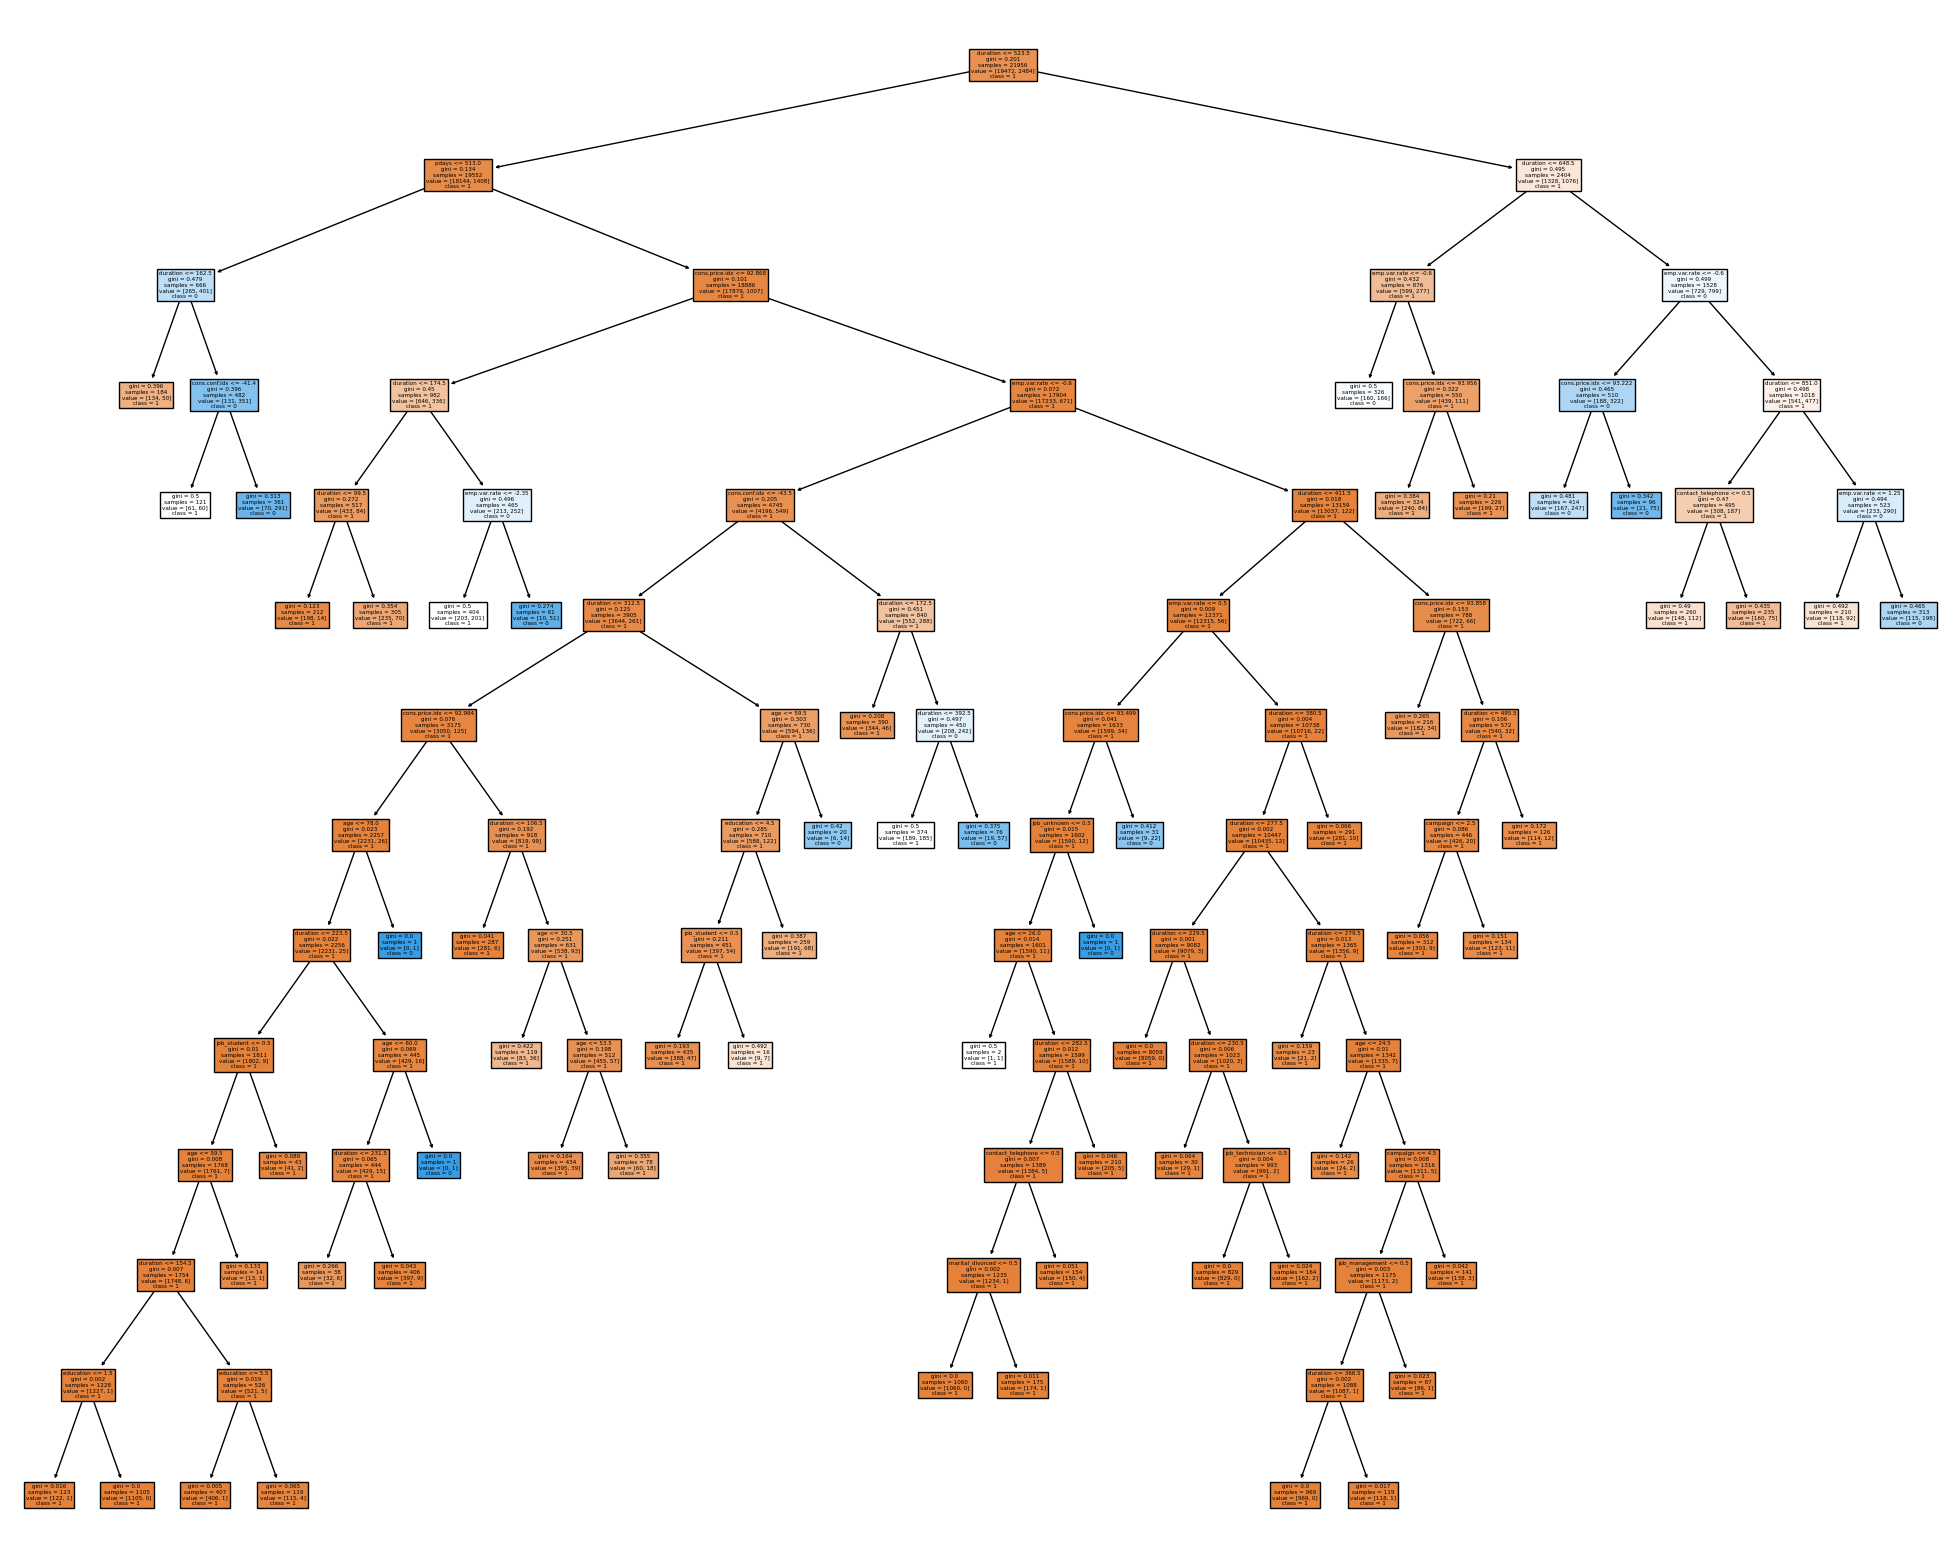

In [24]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dt_model,
                   feature_names=predictors,
                   class_names=['1', '0'],
                   filled=True)

Normalized confusion matrix

Text(0.5, 1.0, 'Confusion matrix of Decision Tree on validation dataset. Mean f1_score=0.785.')

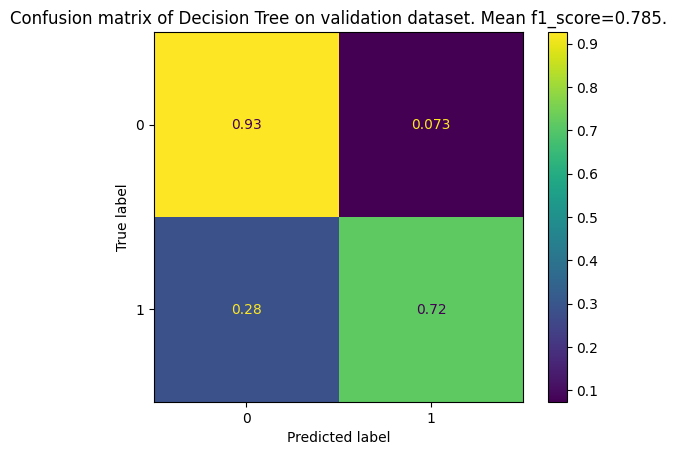

In [25]:
# normalized confusion matrix
mean_val_f1_score = mean(performances.get('validation_f1_score'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred, normalize='true'))
disp.plot()
plt.title(f'Confusion matrix of Decision Tree on validation dataset. Mean f1_score={round(mean_val_f1_score, 3)}.')

Absolute confusion matrix

Text(0.5, 1.0, 'Confusion matrix of Decision Tree on validation dataset.')

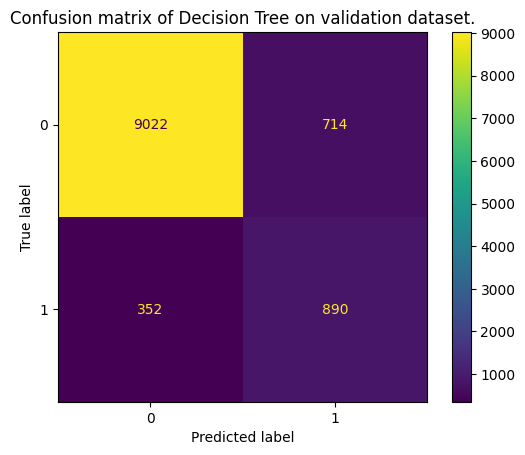

In [26]:
# absolute confusion matrix
mean_val_f1_score = mean(performances.get('validation_f1_score'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
disp.plot()
plt.title(f'Confusion matrix of Decision Tree on validation dataset.')

Text(0.5, 1.0, 'Decision Tree - Feature importance')

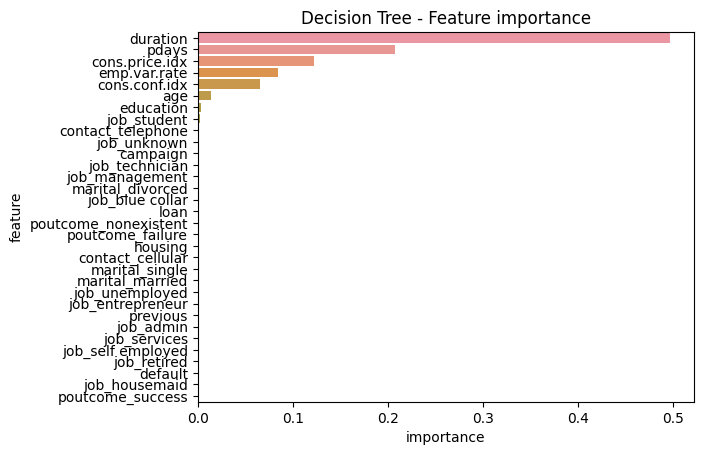

In [27]:
# source: https://stackoverflow.com/questions/69061767/how-to-plot-feature-importance-for-decisiontreeclassifier
feat_importances = pd.DataFrame(
    zip(best_dt_model.feature_importances_, predictors),
    columns=['importance', 'feature']
).sort_values(by='importance', ascending=False)
sns.barplot(feat_importances, y='feature', x='importance').set_title("Decision Tree - Feature importance")

### 3.4. XGBoost

In [28]:
import xgboost as xgb

In [133]:
performances = defaultdict(list)
scoring = 'f1_macro'
for i, (train_index, test_index) in enumerate(skf.split(df_train_val[predictors], df_train_val[target])):
    # split data
    X_train, X_val = df_train_val[predictors].iloc[train_index, :], df_train_val[predictors].iloc[test_index, :]
    y_train, y_val = df_train_val[target][train_index].reset_index(drop=True), df_train_val[target][test_index].reset_index(drop=True)
    print('Running fold:', i)

    if i == 0: # only SEARCH for best hyperparameter once once
        print(f"y_train distribution: 1: {sum(y_train)} | 0: {len(y_train)- sum(y_train) }")
        print(f"y_val distribution: 1: {sum(y_val)} | 0: {len(y_val)- sum(y_val) }")
        i+=1

        # define the model
        xgb_classifier = xgb.XGBClassifier(random_state=random_state)
        # define search space
        parameters = {
            'learning_rate' : [i/100 for i in range(3, 6)],
            'max_depth' : range(10, 50, 10),
            'min_child_weight' : range(3, 7),
            'min_split_loss': [i/10 for i in range(1, 5)],
            'subsample': [i/10 for i in range(2, 10, 2)],
            'colsample_bytree': [i/10 for i in range(5, 10, 2)],
            'lambda': range(1, 4)
        }

        # define search
        search = RandomizedSearchCV(
            estimator=xgb_classifier,
            param_distributions=parameters,
            cv=skf,
            scoring=scoring,
            return_train_score=True,
            random_state=random_state
        )
        # execute search
        result = search.fit(X_train, y_train)
        # report progress
        print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

    # fit the best hyperparameters to the whole training dataset
    best_xgb_model = xgb.XGBClassifier(random_state=random_state, **result.best_params_) # source: https://stackoverflow.com/questions/45074698/how-to-pass-elegantly-sklearns-gridseachcvs-best-parameters-to-another-model
    best_xgb_model.fit(X_train, y_train)

    # get performance metrics
    performance, y_val_pred = compute_performance_metrics(
                    model=best_xgb_model,
                    x_train=X_train,
                    y_train=y_train,
                    x_val=X_val,
                    y_val=y_val,
                    scoring='f1_score',
                    f1_average=f1_average,
                    predict_function='predict_proba'
                )

    for metric in metrics:
        performances[metric].append(performance.get(metric))

    print('======')

Running fold: 0
y_train distribution: 1: 2484 | 0: 19472
y_val distribution: 1: 1242 | 0: 9736
est=0.759, cfg={'subsample': 0.4, 'min_split_loss': 0.3, 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 2, 'colsample_bytree': 0.9}
Optimal threshold: 0.3
Running fold: 1
Optimal threshold: 0.3
Running fold: 2
Optimal threshold: 0.3


In [134]:
# save model performance into a dataframe
performance_data = {
    'train': [
        mean(performances.get('train_f1_score')),
        mean(performances.get('train_precision')),
        mean(performances.get('train_recall'))
    ],
    'val': [
        mean(performances.get('validation_f1_score')),
        mean(performances.get('val_precision')),
        mean(performances.get('val_recall'))
    ]
}
xgb_performance_df = pd.DataFrame.from_dict(
    performance_data,
    orient='index',
    columns=['mean_f1_score', 'mean_precision', 'mean_recall']
).reset_index()

xgb_performance_df['model'] = 'XGBoost'
xgb_performance_df

,index,mean_f1_score,mean_precision,mean_recall,model
0,train,0.829652,0.611110,0.832528,XGBoost
1,val,0.791500,0.554909,0.752281,XGBoost


Normalized confusion matrix

Text(0.5, 1.0, 'Confusion matrix of XGBoost on validation dataset. Mean f1_score=0.792.')

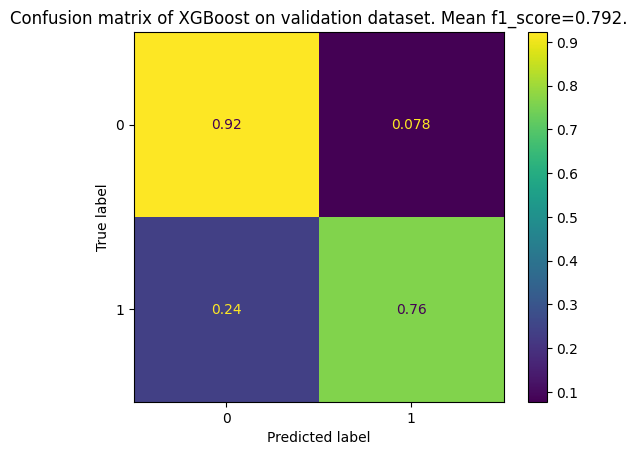

In [31]:
# normalized confusion matrix
mean_val_f1_score = mean(performances.get('validation_f1_score'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred, normalize='true'))
disp.plot()
plt.title(f'Confusion matrix of XGBoost on validation dataset. Mean f1_score={round(mean(mean_val_f1_score), 3)}.')

Text(0.5, 1.0, 'Confusion matrix of XGBoost on validation dataset.')

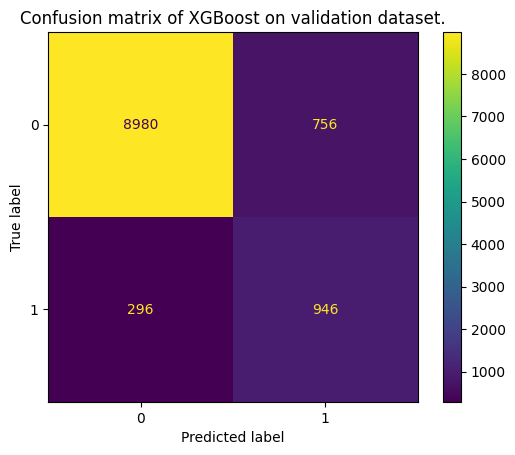

In [32]:
# absolute confusion matrix
mean_val_f1_score = mean(performances.get('validation_f1_score'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
disp.plot()
plt.title(f'Confusion matrix of XGBoost on validation dataset.')

Text(0.5, 1.0, 'XGBoost - Feature importance')

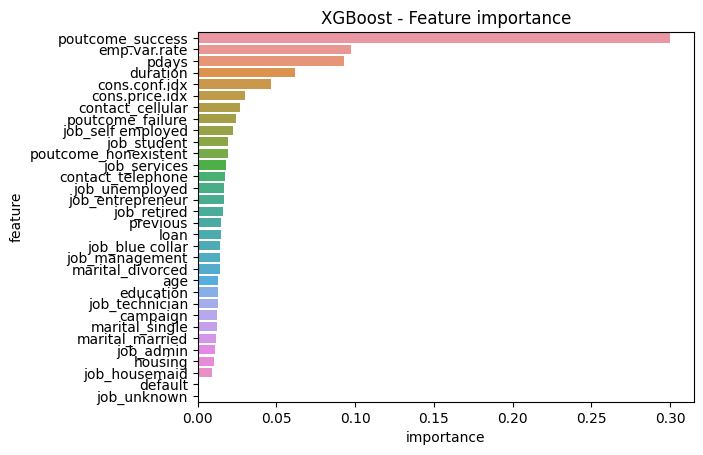

In [33]:
# source: https://stackoverflow.com/questions/69061767/how-to-plot-feature-importance-for-decisiontreeclassifier
feat_importances = pd.DataFrame(
    zip(best_xgb_model.feature_importances_, predictors),
    columns=['importance', 'feature']
).sort_values(by='importance', ascending=False)
sns.barplot(feat_importances, y='feature', x='importance').set_title("XGBoost - Feature importance")

Absolute confusion matrix

## 4. Model selection.

In [154]:
# create a dataframe for baseline performance
baseline_performance_df = pd.DataFrame([
    {'index':'train', 'mean_f1_score': mean(baseline_train_f1_scores), 'model': 'Baseline'},
    {'index':'val', 'mean_f1_score': mean(baseline_val_f1_scores), 'model': 'Baseline'}
], index=[0, 1])

# merge all models' performance metrics
columns = ['mean_f1_score', 'model', 'index']
models_performance_df = pd.concat([
    xgb_performance_df[columns],
    dt_performance_df[columns],
    lr_performance_df[columns],
    bayesian_lr_df[columns],
    baseline_performance_df[columns],
], axis=0)
models_performance_df.rename(columns={'index':'dataset'}, inplace=True)

In [147]:
models_performance_df

,mean_f1_score,model,dataset
0,0.829652,XGBoost,train
1,0.791500,XGBoost,val
0,0.790635,Decision Tree,train
1,0.785152,Decision Tree,val
0,0.774247,Logistic Regression,train
1,0.773735,Logistic Regression,val
0,0.772790,Bayesian Logistic Regression,train
1,0.776420,Bayesian Logistic Regression,val
0,0.470020,Baseline,train
1,0.470020,Baseline,val


([0, 1, 2, 3, 4],
 [Text(0, 0, 'XGBoost'),
  Text(1, 0, 'Decision Tree'),
  Text(2, 0, 'Bayesian Logistic Regression'),
  Text(3, 0, 'Logistic Regression'),
  Text(4, 0, 'Baseline')])

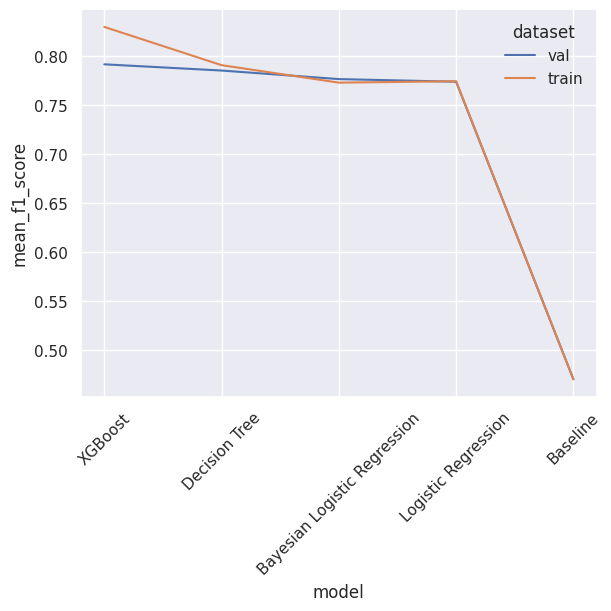

In [162]:
sns.set(rc={'figure.figsize':(6,6)})

models_performance_df = models_performance_df.sort_values(by=['dataset', 'mean_f1_score'], ascending=False)
g = sns.lineplot(models_performance_df, x='model', y='mean_f1_score', hue='dataset')
plt.xticks(rotation=45)

XGBoost is the best model and should be chosen for our project for the two following reasons:
- XGB has the highest mean validation F1 score from the 3-fold cross validation among the 3 models, improving the performance by 69% compared to the baseline, although it is also the most overfitting model, with a higher variance compared to the other two models.
- When comparing the two candidate models, XGB outperforms DT with a higher true positive rate (0.76 vs. 0.73). While it does yield a slightly higher false positive rate (0.078 vs. 0.073), XGB remains the more suitable choice for our context, where correctly targeting potential customers is more valuable than inaccurately targeting a few non-potential ones.


## 5. Assess the final chosen model XGBoost on testing dataset.

In [ ]:
# retrain the data on the whole training set
best_xgb_model = xgb.XGBClassifier(random_state=random_state, **result.best_params_)
best_xgb_model.fit(X_train_val, y_train_val)
y_train_val_pred = best_xgb_model.predict(X_train_val)
train_f1 = f1_score(y_train_val, y_train_val_pred, average=f1_average)
print(f'F1 score on training dataset: {train_f1}')

# test the model's performance on the testing set
y_test_pred = best_xgb_model.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average=f1_average)
print(f'F1 score on testing dataset: {test_f1}')

F1 score on training dataset: 0.8252570834147848
F1 score on testing dataset: 0.7672735050166757


Text(0.5, 1.0, 'Confusion matrix on testing dataset. f1_score=0.767.')

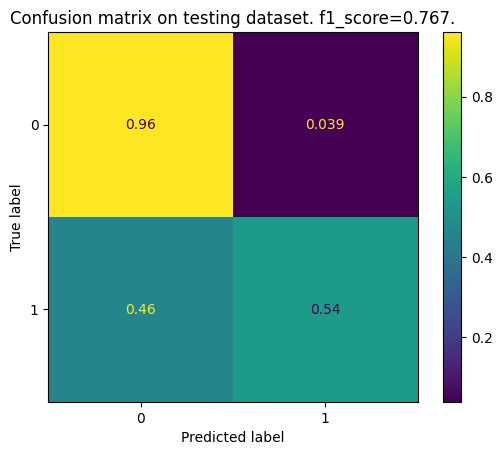

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test, normalize='true')
plt.title(f'Confusion matrix on testing dataset. f1_score={round(test_f1, 3)}.')